In [2]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
korea_trade_path = os.path.join(os.getcwd(), 'source', 'korea_trade.xls')

def excel2Numpy(path):
    dataframe = pd.read_excel(path, header=4, thousands=',')
    dataframe = dataframe.drop(0, axis=0)
    data = np.array(dataframe.drop(dataframe.columns[0], axis=1), dtype=np.float32)
    return data
    
korea_data = excel2Numpy(korea_trade_path)
print(korea_data.shape)

print(korea_data)

(247, 5)
[[  258896. 12162425.   246432. 12594623.  -432198.]
 [  256293. 12676042.   242907. 12023652.   652390.]
 [  313910. 14429703.   293016. 14212011.   217692.]
 ...
 [  799497. 34845744.  2316308. 34459990.   385750.]
 [  987001. 39233904.  2354877. 35613224.  3620677.]
 [ 1032313. 42827384.  2514502. 38693492.  4133894.]]


In [3]:
def normalization(data):
    M = []
    S = []
    
    for i in range(data.shape[-1]):
        M.append(data[:, i].mean())
        S.append(data[:, i].std())
        data[:, i] = (data[:, i] - M[i]) / S[i]
    
    return data, M, S

korea_data, mean, std = normalization(korea_data)

In [4]:
print(korea_data.shape)

sequence_len = 12

def applyWindow(data, SL):
    result = []
    for i in range(len(data) - SL):
        result.append(data[i : i+SL])
    return np.array(result)

print(applyWindow(korea_data, sequence_len + 1).shape)

def seperateData(data, SL):
    result = applyWindow(data, SL)
    
    size = len(result)
    train_data = result[:round(size*0.8), :, :]
    test_data = result[round(size*0.8):, :, :]
    
    train_x = train_data[:, :-1, :]
    train_y = train_data[:, -1, :]
    
    test_x = test_data[:, :-1, :]
    test_y = test_data[:, -1, :]
    
    return (train_x, train_y), (test_x, test_y)

(train_x, train_y), (test_x, test_y) = seperateData(korea_data, sequence_len+1)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(247, 5)
(234, 13, 5)
(187, 12, 5) (187, 5) (47, 12, 5) (47, 5)


In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).\
    shuffle(buffer_size=1000).\
    batch(20, drop_remainder=False)

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(rate=.2)),
    tf.keras.layers.GRU(32, return_sequences=False),
    tf.keras.layers.Dropout(rate=.2),
    tf.keras.layers.Dense(units=16),
    tf.keras.layers.Dense(units=5)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mse', metrics=['accuracy'], optimizer=optimizer)

In [7]:
model.fit(train_dataset, epochs=30, validation_data=(test_x, test_y))

Epoch 1/30
10/10 [==============================] - 1s 64ms/step - loss: 0.5363 - accuracy: 0.2086 - val_loss: 0.7159 - val_accuracy: 0.5957
Epoch 2/30
10/10 [==============================] - 0s 16ms/step - loss: 0.3181 - accuracy: 0.2299 - val_loss: 0.6371 - val_accuracy: 0.5319
Epoch 3/30
10/10 [==============================] - 0s 15ms/step - loss: 0.2386 - accuracy: 0.2834 - val_loss: 0.5487 - val_accuracy: 0.1489
Epoch 4/30
10/10 [==============================] - 0s 15ms/step - loss: 0.2010 - accuracy: 0.4492 - val_loss: 0.4939 - val_accuracy: 0.1915
Epoch 5/30
10/10 [==============================] - 0s 15ms/step - loss: 0.1709 - accuracy: 0.5241 - val_loss: 0.5142 - val_accuracy: 0.1064
Epoch 6/30
10/10 [==============================] - 0s 15ms/step - loss: 0.1576 - accuracy: 0.5508 - val_loss: 0.4750 - val_accuracy: 0.2979
Epoch 7/30
10/10 [==============================] - 0s 14ms/step - loss: 0.1433 - accuracy: 0.6043 - val_loss: 0.4710 - val_accuracy: 0.4255
Epoch 8/30
10

In [8]:
pred = model.predict(train_x)

In [9]:
def accuracy(p, y):
    return int(tf.reduce_mean(tf.cast(abs(p - y) <= abs(y * 0.1), dtype=tf.float32)).numpy() * 100)

def evaluate(p, y):
    plt.figure(figsize=(17, 17))
    for i in range(5):
        predicted_data = p[:, i] * std[i] + mean[i]
        y_data = y[:, i] * std[i] + mean[i]
        plt.subplot(3, 2, i+1)
        plt.title('{} column data => accuracy: {}%'.format(i, accuracy(predicted_data, y_data)))
        plt.plot(predicted_data, 'r-')
        plt.plot(y_data, 'b-')
    plt.show()

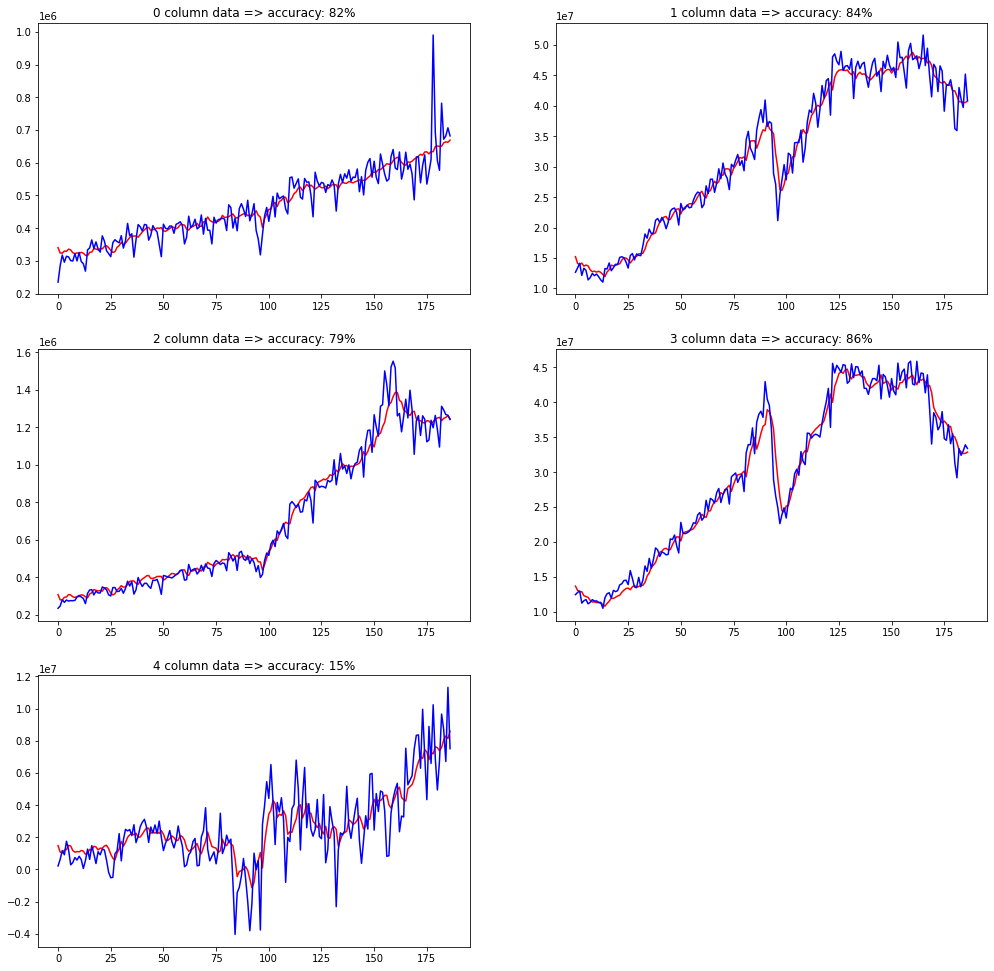

In [10]:
evaluate(pred, train_y)